#<font color=fbb03b>LighGBMを使用

#<font color=fbb03b>事前準備

In [ ]:
# ライブラリのインストール
!pip install yfinance
!pip install japanize_matplotlib

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from tqdm import tqdm
import datetime

import lightgbm as lgb

import yfinance

#<font color=fbb03b>1. 国内株価データの取得と確認



In [ ]:
# 株価を取得してみる
t = yfinance.download("8411.T") # 試しに, みずほフィナンシャルグループをDownload

# 取得した株価の確認
t

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-03-12,1040.0,1100.0,1020.0,1060.0,528.371826,22786900
2003-03-13,1110.0,1130.0,1080.0,1120.0,558.279602,10959500
2003-03-14,1140.0,1150.0,1060.0,1070.0,533.356567,8088200
2003-03-17,1050.0,1050.0,981.0,981.0,488.993103,7946300
2003-03-18,1000.0,1020.0,967.0,971.0,484.008575,11310000
...,...,...,...,...,...,...
2024-08-29,3020.0,3024.0,2991.0,2997.0,2997.000000,6360700
2024-08-30,3010.0,3027.0,2985.5,3009.0,3009.000000,11370200
2024-09-02,3050.0,3068.0,3030.0,3059.0,3059.000000,7323800


<Axes: xlabel='Date'>

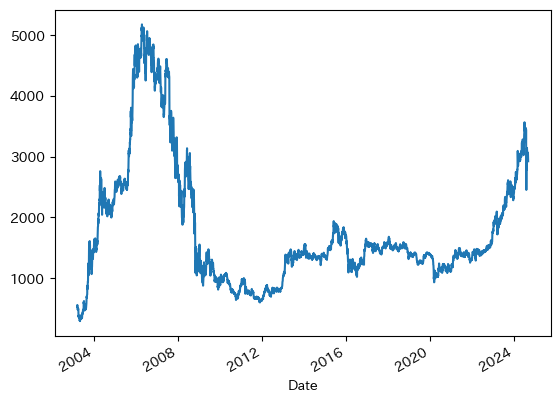

In [ ]:
# データの可視化
t["Adj Close"].plot()

In [ ]:
# TOPIX 100銘柄に対象を絞る
topix_100 = [
    "1925",
    "1928",
    "2413",
    "2502",
    "2503",
    "2802",
    "2914",
    "3382",
    "3402",
    "3407",
    "4063",
    "4188",
    "4452",
    "4502",
    "4503",
    "4507",
    "4519",
    "4523",
    "4528",
    "4543",
    "4568",
    "4578",
    "4661",
    "4689",
    "4901",
    "4911",
    "5020",
    "5108",
    "5401",
    "5713",
    "5802",
    "6098",
    "6178",
    "6273",
    "6301",
    "6326",
    "6367",
    "6501",
    "6502",
    "6503",
    "6594",
    "6645",
    "6702",
    "6723",
    "6752",
    "6758",
    "6861",
    "6869",
    "6902",
    "6920",
    "6954",
    "6971",
    "6981",
    "7011",
    "7201",
    "7203",
    "7267",
    "7269",
    "7270",
    "7309",
    "7733",
    "7741",
    "7751",
    "7832",
    "7974",
    "8001",
    "8002",
    "8031",
    "8035",
    "8053",
    "8058",
    "8113",
    "8267",
    "8306",
    "8308",
    "8309",
    "8316",
    "8411",
    "8591",
    "8604",
    "8630",
    "8697",
    "8725",
    "8750",
    "8766",
    "8801",
    "8802",
    "8830",
    "9020",
    "9021",
    "9022",
    "9101",
    "9202",
    "9432",
    "9433",
    "9434",
    "9735",
    "9843",
    "9983",
    "9984",
]

In [ ]:
# TOPIX100の銘柄のデータを全て取得する
data_list = []
for code in tqdm(topix_100):
    tmp = yfinance.download(f"{str(code)}.T", progress=False)
    tmp["code"] = code
    data_list.append(tmp)

 38%|███▊      | 38/100 [00:13<00:25,  2.47it/s]ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['6502.T']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
100%|██████████| 100/100 [00:34<00:00,  2.91it/s]


In [ ]:
# 複数のデータフレームを縦方向に結合する
df = pd.concat(data_list)

# データフレームを表示
df

<ipython-input-95-eaa26a9564b0>:2: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df = pd.concat(data_list)


,Open,High,Low,Close,Adj Close,Volume,code
Date,,,,,,,
2000-01-04,761.0,764.0,745.0,746.0,413.600983,462000.0,1925
2000-01-05,765.0,775.0,761.0,774.0,429.124756,937000.0,1925
2000-01-06,784.0,791.0,770.0,770.0,426.906982,1315000.0,1925
2000-01-07,770.0,774.0,745.0,751.0,416.372925,1116000.0,1925
2000-01-10,751.0,751.0,751.0,751.0,416.372925,0.0,1925
...,...,...,...,...,...,...,...
2024-08-29,8211.0,8247.0,8133.0,8145.0,8145.000000,16381200.0,9984
2024-08-30,8271.0,8419.0,8261.0,8405.0,8405.000000,11897400.0,9984
2024-09-02,8540.0,8604.0,8390.0,8481.0,8481.000000,9465300.0,9984


#<font color=fbb03b>2. 海外の株価指数データの取得と確認

- 各指数のシンボルを入力として与えればよい.
- 例えばS&P500であればシンボルは^GSPCとなる.
- シンボルはyahoo finance!で確認する.

In [ ]:
# S&P500指数（^GSPC）の株価データをダウンロード
df_external= yfinance.download("^GSPC", progress=False)

# ダウンロードしたデータの確認
df_external

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0
1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0
1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0
1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0
1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0
...,...,...,...,...,...,...
2024-08-30,5612.740234,5651.370117,5581.790039,5648.399902,5648.399902,4185850000
2024-09-03,5623.890137,5623.890137,5504.330078,5528.930176,5528.930176,3866350000
2024-09-04,5506.680176,5552.990234,5503.660156,5520.069824,5520.069824,3478140000


簡単な分析として, S&P500が上昇した場合

次の日, 日本株は上昇して始まる.
そのタイミングで逆張りをした場合どうなるかを見てみる.

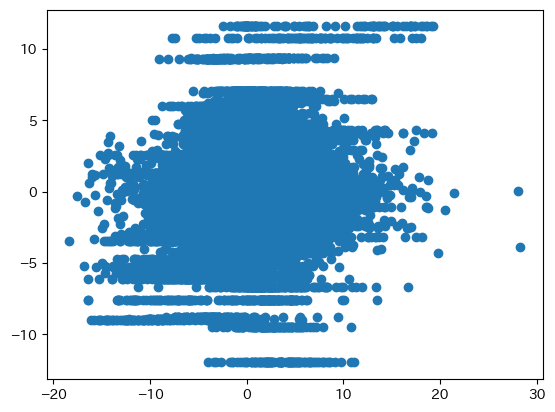

In [ ]:
# 寄り⇒引けの変動率
df["寄り引け変動率"] = (df["Close"] - df["Open"])/df["Open"] * 100

# S&P500の前日比
df_external["S&P500前日比"] = df_external["Close"].pct_change() * 100

# アメリカの日付と日本の日付を合わせて結合する
# 1日アメリカの値をシフトさせる(休日などの影響で正しくない日もあるので厳密ではない)
df_external = df_external.shift(1)

df_merge = pd.merge(
    df.loc[df.index < datetime.datetime(2023, 2, 8)],
    df_external[["S&P500前日比"]],
    left_index=True,
    right_index=True,
    how="left",
)

plt.scatter(x="寄り引け変動率", y="S&P500前日比", data=df_merge);

In [ ]:
df_merge["year"] = df_merge.index.year
df_merge.groupby("year")[["寄り引け変動率","S&P500前日比"]].corr()

寄り引け変動率  S&P500前日比
year                               
1999 寄り引け変動率    1.000000   0.090585
     S&P500前日比  0.090585   1.000000
2000 寄り引け変動率    1.000000  -0.069964
     S&P500前日比 -0.069964   1.000000
2001 寄り引け変動率    1.000000  -0.101590
     S&P500前日比 -0.101590   1.000000
2002 寄り引け変動率    1.000000  -0.084232
     S&P500前日比 -0.084232   1.000000
2003 寄り引け変動率    1.000000  -0.041137
     S&P500前日比 -0.041137   1.000000
2004 寄り引け変動率    1.000000  -0.072275
     S&P500前日比 -0.072275   1.000000
2005 寄り引け変動率    1.000000  -0.060471
     S&P500前日比 -0.060471   1.000000
2006 寄り引け変動率    1.000000  -0.064469
     S&P500前日比 -0.064469   1.000000
2007 寄り引け変動率    1.000000  -0.045775
     S&P500前日比 -0.045775   1.000000
2008 寄り引け変動率    1.000000   0.383615
     S&P500前日比  0.383615   1.000000
2009 寄り引け変動率    1.000000   0.222249
     S&P500前日比  0.222249   1.000000
2010 寄り引け変動率    1.000000  -0.070906
     S&P500前日比 -0.070906   1.000000
2011 寄り引け変動率    1.000000  -0.066983
     S&P500前日比 -0.066983   1.000000
2012 寄り引け変動率    1.000000  -0.039472
     S&P500前日比 -0.039472   1.000000
2013 寄り引け変動率    1.000000  -0.025640
     S&P500前日比 -0.025640   1.000000
2014 寄り引け変動率    1.000000   0.011265
     S&P500前日比  0.011265   1.000000
2015 寄り引け変動率    1.000000  -0.010937
     S&P500前日比 -0.010937   1.000000
2016 寄り引け変動率    1.000000  -0.038903
     S&P500前日比 -0.038903   1.000000
2017 寄り引け変動率    1.000000  -0.035203
     S&P500前日比 -0.035203   1.000000
2018 寄り引け変動率    1.000000  -0.028743
     S&P500前日比 -0.028743   1.000000
2019 寄り引け変動率    1.000000  -0.126601
     S&P500前日比 -0.126601   1.000000
2020 寄り引け変動率    1.000000  -0.152452
     S&P500前日比 -0.152452   1.000000
2021 寄り引け変動率    1.000000  -0.033019
     S&P500前日比 -0.033019   1.000000
2022 寄り引け変動率    1.000000   0.009824
     S&P500前日比  0.009824   1.000000
2023 寄り引け変動率    1.000000   0.003628
     S&P500前日比  0.003628   1.000000

In [ ]:
df_merge.loc[df_merge["S&P500前日比"]>0, "S&P500_up"] = 1
df_merge.loc[df_merge["S&P500前日比"]<0, "S&P500_up"] = 0

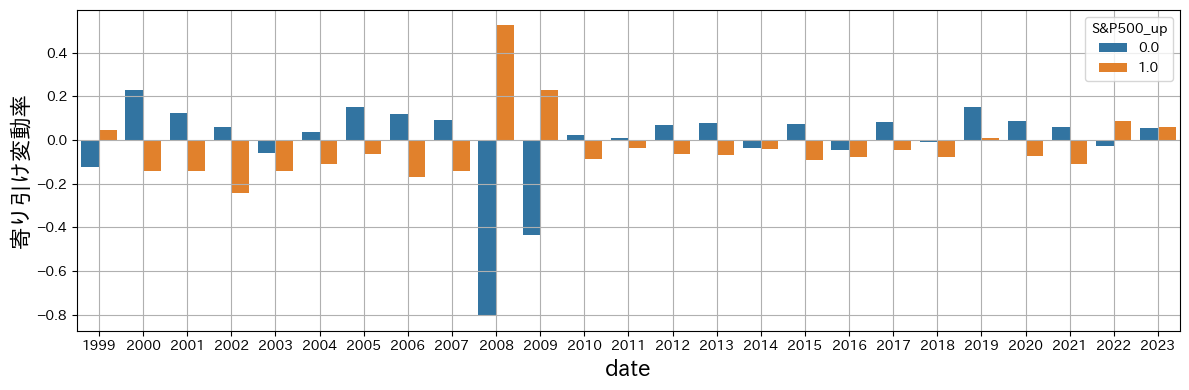

In [ ]:
df_agg = df_merge.groupby(["year", "S&P500_up"])["寄り引け変動率"].mean().reset_index()
fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x="year", y="寄り引け変動率", data=df_agg, hue="S&P500_up")
ax.set_xlabel("date", fontsize=16)
ax.set_ylabel("寄り引け変動率", fontsize=16)
plt.grid()
plt.tight_layout()

S&P500が上昇した場合, 日本株は日中下落する傾向がある.
直近二年間は逆転している.

In [ ]:
# 前日_前日比
df_merge["前日比"] = df_merge.groupby("code")["Close"].pct_change(1)
df_merge["前日比"] = df_merge.groupby("code")["前日比"].shift(1)

In [ ]:
# 前日_始値⇒終値
df_merge["始値_終値"] = (df_merge["Close"] - df_merge["Open"]) / df_merge["Open"]
df_merge["始値_終値"] = df_merge.groupby("code")["始値_終値"].shift(1)

# 25日移動平均乖離率
day = 25
df_merge_ma = df_merge.groupby("code")["Close"].rolling(window=day).mean().reset_index()
df_merge[f"乖離率{day}日"] = (df_merge["Close"].values / df_merge_ma["Close"].values)
df_merge[f"乖離率{day}日"] = df_merge.groupby("code")[f"乖離率{day}日"].shift(1)

In [ ]:
target = '寄り引け変動率' # 何を予測するか
features = ['前日比', '始値_終値', '乖離率25日', 'S&P500前日比'] # 何を入力とするか

#<font color=fbb03b>3. 深層学習にLightGBMを使用

LightGBMは高速で効率的な勾配ブースティング決定木アルゴリズムで, 以下の特徴がある:

1. ヒストグラムベースの学習により, 計算速度が向上し, メモリ使用量が削減される.

2. リーフ単位で木を成長させる手法により, より深い木を効率的に構築できる.

3. カテゴリ変数の最適な分割を効率的に見つけ出す機能がある.

4. 分散学習に最適化されており, 大規模データセットでも高性能を発揮する.

株価予測への応用では, これらの特徴により大量の市場データを高速に処理でき, 複雑な非線形パターンを捉えることが可能になる. また, カテゴリカル変数（例：業種コード）の効率的な扱いや, 分散学習による大規模データセットの処理能力は, 多様な要因を考慮する株価予測に適している.

ドキュメント: https://lightgbm.readthedocs.io/en/latest/index.html

github: https://github.com/microsoft/LightGBM

##<font color=fbb03b>3.1 データ準備

In [ ]:
# 学習データと検証データに分割する
# 2021年1月1日を境に学習データと検証データに分割
train_idx = df_merge.index < datetime.datetime(2021, 1 ,1)
valid_idx = df_merge.index > datetime.datetime(2021, 1 ,1)

df_train = df_merge.loc[train_idx, :]
df_valid = df_merge.loc[valid_idx, :]

##<font color=fbb03b>3.2 モデル構築

In [ ]:
# LightGBMの学習パラメータを設定
params = {
    "learning_rate": 0.1,
    'objective' : 'regression',
    "seed": 1,
    "verbosity": -1,
}

# データセットの作成（学習データと検証データをLightGBMのDataset形式に変換）
dtrain = lgb.Dataset(
    df_train[features],
    df_train[target],
)
dvalid = lgb.Dataset(
    df_valid[features],
    df_valid[target],
)

##<font color=fbb03b>3.3 モデルの学習

In [ ]:
# evals_resultはcallbackで記録するように変更
evals_result = {}  # 評価結果を格納する辞書
model = lgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    valid_sets=[dtrain, dvalid],
    valid_names=["train", "valid"],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),  # early stopping
        lgb.log_evaluation(period=100),  # ログ表示
        lgb.record_evaluation(evals_result)  # 評価結果を記録
    ]
)

# evals_resultを表示する
print("Evaluation results:", evals_result)

Training until validation scores don't improve for 100 rounds
[100]	train's l2: 2.76941	valid's l2: 1.88399
Early stopping, best iteration is:
[1]	train's l2: 2.94023	valid's l2: 1.85729
Evaluation results: {'train': OrderedDict([('l2', [2.940227006844676, 2.9301023985096197, 2.9217169055028633, 2.914302874008285, 2.907389185839422, 2.901793224366807, 2.896685940305077, 2.892296736521704, 2.8885907754812035, 2.885040842437955, 2.88214104155179, 2.8790445865378973, 2.875395852440083, 2.8725571282586615, 2.869744551997602, 2.8673542432209755, 2.865113337495919, 2.8625475997589405, 2.860824589817379, 2.8589405476510157, 2.85602629776025, 2.8543665462253474, 2.852347943829927, 2.8502602238861905, 2.848120203020884, 2.846509897869046, 2.844950055094707, 2.843268805976923, 2.841865403959295, 2.840560198649338, 2.8385463328972977, 2.8369262306060055, 2.8356192392780466, 2.8344416788772153, 2.8330563079875266, 2.831507296701218, 2.830230368053341, 2.8286336809365165, 2.8273959226863945, 2.8259

##<font color=fbb03b>3.4 予測に寄与した特徴量を可視化して確認

 特徴量とその重要度を格納するDataFrameを作成し, 降順にソートして表示することで,  どの特徴量がモデルの予測に最も影響を与えているか可視化します.

In [ ]:
df_importance = pd.DataFrame()

# モデルで使用された特徴量の名前を取得
df_importance["feature"] = model.feature_name()

# 各特徴量の重要度を計算. gainは, 特徴量がモデルの予測にどれだけ貢献したかを示す指標
df_importance["重要度"] = model.feature_importance(importance_type="gain")

display(df_importance.sort_values("重要度", ascending=False))

,feature,重要度
3,S&P500前日比,14269.398819
1,始値_終値,8702.135986
0,前日比,4839.795044
2,乖離率25日,2580.260956


##<font color=fbb03b>3.5 予測値に基づいたランキングとポジション決定

検証データに対して予測を行い, 予測値に基づいてランキングを付けます.

In [ ]:
valid_pred = model.predict(df_valid[features]) # 検証データに対して予測を行い, 予測値を取得します

df_eval = df_valid.copy()
df_eval["prediction"] = valid_pred

# 各日付（level=0）ごとに予測値を降順にソートし, ランク付けを行います
df_eval["rank"] = df_eval.groupby(level=0)["prediction"].rank()

df_eval = df_eval[[target, "prediction", "rank"]]

print(df_eval)

             寄り引け変動率  prediction  rank
Date                                  
2021-01-04 -1.457726   -0.030846  49.0
2021-01-04 -1.802434   -0.030846  49.0
2021-01-04  3.067733   -0.030846  49.0
2021-01-04 -1.548205   -0.030846  49.0
2021-01-04 -2.263840   -0.030846  49.0
...              ...         ...   ...
2023-02-07  0.757077   -0.019829  49.0
2023-02-07 -0.013130   -0.019829  49.0
2023-02-07 -0.205459   -0.019829  49.0
2023-02-07 -0.301898   -0.019829  49.0
2023-02-07 -0.571066   -0.019829  49.0

[50787 rows x 3 columns]


###<font color=fbb03b> ポジションの決定

予測値のランキングに基づいて, "買い", "売り"のポジションを決定します.

80%タイルと20%タイル:
- 予測値の上位20%を"買い", 下位20%を"売り"と判断するための閾値として利用されます.

ポジション決定:
- 予測値のランクが80%タイルを超える場合は"買い", 20%タイルを下回る場合は"売り"とします. それ以外の場合はポジションを持たない, というロジックになっています.

In [ ]:
# 80%タイルを取得
df_eval = pd.merge(
    df_eval,
    df_eval.groupby(level=0)["rank"].quantile(0.8).rename("quantile_80"),
    left_index=True,
    right_index=True,
    how="left",
)

# 20%タイルを取得
df_eval = pd.merge(
    df_eval,
    df_eval.groupby(level=0)["rank"].quantile(0.2).rename("quantile_20"),
    left_index=True,
    right_index=True,
    how="left",
)

# ポジションを決定
df_eval.loc[df_eval["rank"]>df_eval["quantile_80"], "position"] = "買い"
df_eval.loc[df_eval["rank"]<df_eval["quantile_20"], "position"] = "売り"
df_eval = df_eval[~df_eval["position"].isnull()]

df_eval

,寄り引け変動率,prediction,rank,quantile_80,quantile_20,position
Date,,,,,,
2021-01-04,-1.457726,-0.030846,49.0,49.0,49.0,na
2021-01-04,-1.802434,-0.030846,49.0,49.0,49.0,na
2021-01-04,3.067733,-0.030846,49.0,49.0,49.0,na
2021-01-04,-1.548205,-0.030846,49.0,49.0,49.0,na
2021-01-04,-2.263840,-0.030846,49.0,49.0,49.0,na
...,...,...,...,...,...,...
2023-02-07,0.757077,-0.019829,49.0,49.0,49.0,na
2023-02-07,-0.013130,-0.019829,49.0,49.0,49.0,na
2023-02-07,-0.205459,-0.019829,49.0,49.0,49.0,na


###<font color=fbb03b> 損益計算と可視化

決定されたポジションに基づいて, 各日のリターンを計算し, 累積リターンをプロットします.

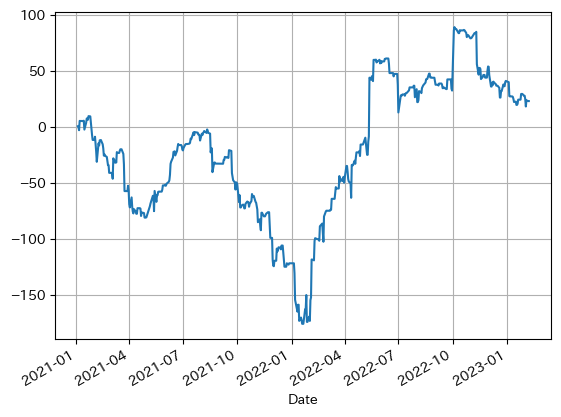

In [ ]:
# ポジションが"買い"の場合は寄り引け変動率, "売り"の場合は寄り引け変動率のマイナス値を返す.
def get_return(x):
    if x["position"] == "売り":
        return -x["寄り引け変動率"]
    elif x["position"] == "買い":
        return x["寄り引け変動率"]

# 計算されたリターンを新しいカラムreturnに追加
df_eval["return"] = df_eval.apply(get_return, axis=1)

# 各日のリターンを累積することで、戦略全体の収益性を評価します。
df_eval.groupby(level=0)["return"].sum().cumsum().plot()

plt.grid()